# Spaceship Titanic
[Kaggle Competiton](https://www.kaggle.com/competitions/spaceship-titanic/)


    - PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    - HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    - CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    - Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    - Destination - The planet the passenger will be debarking to.
    - Age - The age of the passenger.
    - VIP - Whether the passenger has paid for special VIP service during the voyage.
    - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    - Name - The first and last names of the passenger.
    - Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.



In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb

def convert(dataframe):
    dataframe["HomePlanet"]=dataframe["HomePlanet"].astype("category")
    dataframe["Destination"]=dataframe["Destination"].astype("category")
    dataframe[["group", "number_within_group"]]=dataframe["PassengerId"].str.split("_", expand=True)
    dataframe["group"]=dataframe["group"].astype(int)
    dataframe["number_within_group"]=dataframe["number_within_group"].astype(int)
    dataframe[["deck", "num", "side"]]=dataframe["Cabin"].str.split("/", expand=True)
    dataframe["deck"]=dataframe["deck"].astype("category")
    dataframe["num"]=dataframe["num"].astype("category")
    dataframe["side"]=dataframe["side"].astype("category")
    dataframe = dataframe.drop(["Cabin", "PassengerId", "Name"], axis=1) #also remove name
    dataframe["CryoSleep"] =dataframe["CryoSleep"].astype(bool)
    dataframe["VIP"] =dataframe["VIP"].astype(bool)
    dataframe["Age"]=pd.to_numeric(dataframe['Age'], errors='coerce', downcast='integer')
    dataframe["RoomService"]=pd.to_numeric(dataframe['RoomService'], errors='coerce', downcast='integer')
    dataframe["FoodCourt"]=pd.to_numeric(dataframe['FoodCourt'], errors='coerce', downcast='integer')
    dataframe["ShoppingMall"]=pd.to_numeric(dataframe['ShoppingMall'], errors='coerce', downcast='integer')
    dataframe["Spa"]=pd.to_numeric(dataframe['Spa'], errors='coerce', downcast='integer')
    dataframe["VRDeck"]=pd.to_numeric(dataframe['VRDeck'], errors='coerce', downcast='integer')
    return dataframe


mnist_train = pd.read_csv("/home/rainer/Downloads/ML_datasets/spaceship_titanic_train.csv")
mnist_train = convert(mnist_train)
mnist_train["Transported"] =mnist_train["Transported"].astype(bool)

X, Y = mnist_train.drop('Transported', axis=1), mnist_train[['Transported']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)
dtrain_reg = xgb.DMatrix(X_train, Y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, Y_test, enable_categorical=True)

In [2]:
mnist_train.dtypes

HomePlanet             category
CryoSleep                  bool
Destination            category
Age                     float64
VIP                        bool
RoomService             float64
FoodCourt               float64
ShoppingMall            float64
Spa                     float64
VRDeck                  float64
Transported                bool
group                     int64
number_within_group       int64
deck                   category
num                    category
side                   category
dtype: object

In [3]:
mnist_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,group,number_within_group,deck,num,side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,1,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,1,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3,1,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3,2,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4,1,F,1,S


In [4]:
# Define hyperparameters (search by optuna
params = {
    "objective": "binary:hinge",
    "tree_method": "gpu_hist",
    "eta": 0.10639974467535045,
    "max_depth": 10,
    "min_child_weight": 10.486339500146217,
    "subsample": 0.9875003085612942,
    "colsample_bynode": 0.18579214962585772
}
boostround=200
results = xgb.cv(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=boostround,
    nfold=5,
    verbose_eval=10, # print eval every xth round
    metrics=["logloss", "error"],
)

[0]	train-logloss:18.40655+0.12457	train-error:0.49962+0.00338	test-logloss:18.40644+0.49841	test-error:0.49961+0.01353
[10]	train-logloss:8.17330+0.16618	train-error:0.22185+0.00451	test-logloss:9.59036+0.37915	test-error:0.26031+0.01029
[20]	train-logloss:6.56832+0.10761	train-error:0.17829+0.00292	test-logloss:7.74801+0.34553	test-error:0.21031+0.00938
[30]	train-logloss:6.33379+0.12879	train-error:0.17192+0.00350	test-logloss:7.51632+0.18502	test-error:0.20402+0.00502
[40]	train-logloss:6.10067+0.16071	train-error:0.16559+0.00436	test-logloss:7.46547+0.22387	test-error:0.20264+0.00608
[50]	train-logloss:5.81104+0.12380	train-error:0.15773+0.00336	test-logloss:7.41460+0.22328	test-error:0.20126+0.00606
[60]	train-logloss:5.52423+0.12639	train-error:0.14995+0.00343	test-logloss:7.34113+0.28560	test-error:0.19926+0.00775
[70]	train-logloss:5.22894+0.12838	train-error:0.14193+0.00348	test-logloss:7.30723+0.21760	test-error:0.19834+0.00591
[80]	train-logloss:4.97605+0.16149	train-error:

In [5]:
results.iloc[-1]["test-error-mean"]

0.202026470297426

In [6]:
dfull = xgb.DMatrix(X, Y, enable_categorical=True)
model = xgb.train(
    params=params,
    dtrain=dfull,
    num_boost_round=boostround
)
mnist_test = pd.read_csv("/home/rainer/Downloads/ML_datasets/spaceship_titanic_test.csv")
spaceship_finalPred = convert(mnist_test)
spaceship_finalPred_matrix = xgb.DMatrix(spaceship_finalPred, enable_categorical=True)
predictions = model.predict(spaceship_finalPred_matrix)
predictionsDf = pd.DataFrame(predictions, columns=["Transported"])
predictionsDf["PassengerId"]=mnist_test["PassengerId"]
predictionsDf=predictionsDf[["PassengerId","Transported"]]
predictionsDf["Transported"]=predictionsDf["Transported"].astype(bool)

In [7]:
predictionsDf

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [8]:
predictionsDf.to_csv('/home/rainer/Downloads/ML_datasets/spaceship_titanic_test_prediction.csv', index=False)

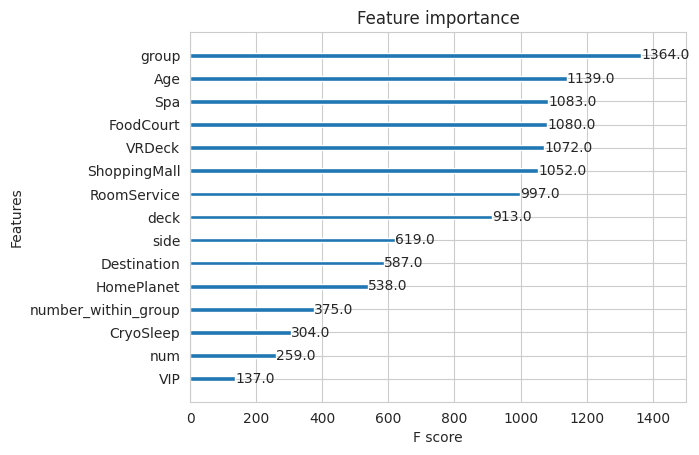

In [9]:
# plot feature importance
from matplotlib import pyplot as plt
xgb.plot_importance(model)
plt.show()